In [64]:
import numpy as np
import matplotlib.pyplot as plt
from util_func import *
import sklearn
import sklearn.datasets
import scipy.io
from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize']=(7.0,6.0)
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gray'



In [65]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import sklearn
import sklearn.datasets
import sklearn.linear_model
import scipy.io

def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

def relu(x):
    """
    Compute the relu of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- relu(x)
    """
    s = np.maximum(0,x)
    
    return s

def load_planar_dataset(seed):
    
    np.random.seed(seed)
    
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    b1 -- bias vector of shape (layer_dims[l], 1)
                    Wl -- weight matrix of shape (layer_dims[l-1], layer_dims[l])
                    bl -- bias vector of shape (1, layer_dims[l])
                    
   
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == layer_dims[l], layer_dims[l-1])
        assert(parameters['W' + str(l)].shape == layer_dims[l], 1)

        
    return parameters

def forward_propagation(X, parameters):
    """
    Implements the forward propagation (and computes the loss) presented in Figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape ()
                    b1 -- bias vector of shape ()
                    W2 -- weight matrix of shape ()
                    b2 -- bias vector of shape ()
                    W3 -- weight matrix of shape ()
                    b3 -- bias vector of shape ()
    
    Returns:
    loss -- the loss function (vanilla logistic loss)
    """
        
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

def backward_propagation(X, Y, cache):
    """
    Implement the backward propagation presented in figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat)
    cache -- cache output from forward_propagation()
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(i)] = Wi
                    parameters['b' + str(i)] = bi
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(i)] = dWi
                    grads['db' + str(i)] = dbi
    learning_rate -- the learning rate, scalar.
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    
    n = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for k in range(n):
        parameters["W" + str(k+1)] = parameters["W" + str(k+1)] - learning_rate * grads["dW" + str(k+1)]
        parameters["b" + str(k+1)] = parameters["b" + str(k+1)] - learning_rate * grads["db" + str(k+1)]
        
    return parameters

def predict(X, y, parameters):
    """
    This function is used to predict the results of a  n-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)
    
    # Forward propagation
    a3, caches = forward_propagation(X, parameters)
    
    # convert probas to 0/1 predictions
    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    # print results

    #print ("predictions: " + str(p[0,:]))
    #print ("true labels: " + str(y[0,:]))
    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

def compute_cost(a3, Y):
    """
    Implement the cost function
    
    Arguments:
    a3 -- post-activation, output of forward propagation
    Y -- "true" labels vector, same shape as a3
    
    Returns:
    cost - value of the cost function
    """
    m = Y.shape[1]
    
    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    cost = 1./m * np.nansum(logprobs)
    
    return cost

def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    train_set_x_orig = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
    test_set_x_orig = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
    
    train_set_x = train_set_x_orig/255
    test_set_x = test_set_x_orig/255

    return train_set_x, train_set_y, test_set_x, test_set_y, classes


def predict_dec(parameters, X):
    """
    Used for plotting decision boundary.
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (m, K)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Predict using forward propagation and a classification threshold of 0.5
    a3, cache = forward_propagation(X, parameters)
    predictions = (a3>0.5)
    return predictions

def load_planar_dataset(randomness, seed):
    
    np.random.seed(seed)
    
    m = 50
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 2 # maximum ray of the flower

    for j in range(2):
        
        ix = range(N*j,N*(j+1))
        if j == 0:
            t = np.linspace(j, 4*3.1415*(j+1),N) #+ np.random.randn(N)*randomness # theta
            r = 0.3*np.square(t) + np.random.randn(N)*randomness # radius
        if j == 1:
            t = np.linspace(j, 2*3.1415*(j+1),N) #+ np.random.randn(N)*randomness # theta
            r = 0.2*np.square(t) + np.random.randn(N)*randomness # radius
            
        X[ix] = np.c_[r*np.cos(t), r*np.sin(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y.ravel(), cmap=plt.cm.Spectral)
    plt.show()
    
def load_2D_dataset():
    data = scipy.io.loadmat('data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T

    plt.scatter(train_X[0, :], train_X[1, :],c=train_Y.ravel(), s=40, cmap=plt.cm.Spectral);
    
    return train_X, train_Y, test_X, test_Y


<ipython-input-65-c533d1274d91>:82: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(parameters['W' + str(l)].shape == layer_dims[l], layer_dims[l-1])
<ipython-input-65-c533d1274d91>:83: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(parameters['W' + str(l)].shape == layer_dims[l], 1)


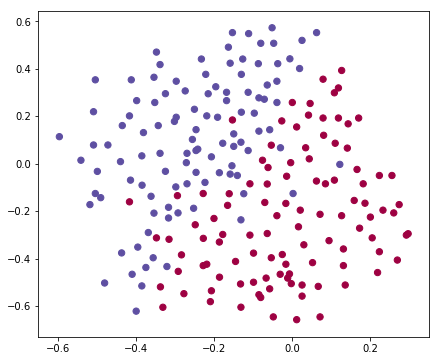

In [66]:
data = scipy.io.loadmat('data.mat')
train_X = data['X'].T
train_Y = data['y'].T
test_X = data['Xval'].T
test_Y = data['yval'].T

plt.scatter(train_X[0, :], train_X[1, :],c=train_Y.ravel(), s=40, cmap=plt.cm.Spectral);

ValueError: too many values to unpack (expected 3)

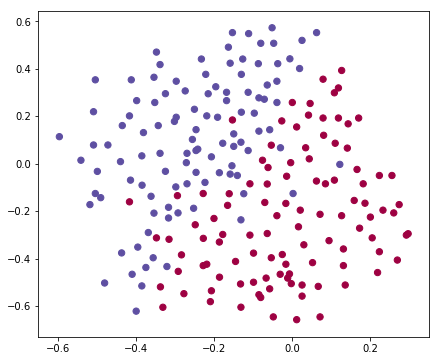

In [67]:
train_X, train_Y, test_Y=load_2D_dataset()

In [68]:
def model(X,Y,learning_rate=0.3, num_iteration=30000, print_cost=True, lambd=0, keep_probs=1):
    
    grads={}
    costs=[]
    m=X.shape[1]
    layer_dims=[X.shape[0],20,3,1]

    parameters=initialize_parameters(layer_dims)

    for i in range(0,num_iteration):
    
        if keep_probs==1:
            a3, cache= forward_propagation(X, parameters)
    
        elif keep_probs<1:
            a3, cache= forward_propagation_with_dropout_test_case(X, parameters, keep_probs)
        
        if lambd ==0:
            cost= compute_cost(a3,Y)
        else:
            cost=compute_cost_with_regularization_test_case(a3,Y,parameters, lambd)
        
        
    #backward prpopogation
    
        assert(lambd==0 or keep_probs==1)
    
        if lambd==0 and keep_probs == 1:
            grads=backward_propagation(X,Y,cache)
        
        elif lambd!=0:
            grads=backward_propagation_with_regularization_test_case(X,Y, cache. lambd)
            
        elif keep_probs<1:
            grads=backward_propagation_with_dropout_test_case(X,Y, keep_probs)
        
        parameters=update_parameters(parameters, grads, learning_rate)
    
        if print_cost and i%1000==0:
            print("Cost after iteration{}: {}".format(i,cost))
        
        if print_cost and i%1000==0:
            costs.append(cost)
        
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iteration')
    #plt.title("learning rate=" +str(learning))
    
    plt.show()
    
    return parameters
    
    
    

Cost after iteration0: 0.6557412523481002
Cost after iteration1000: 0.2222669386845115
Cost after iteration2000: 0.20288702607598852
Cost after iteration3000: 0.18251497924686957
Cost after iteration4000: 0.18053978306217752
Cost after iteration5000: 0.17620471758400447
Cost after iteration6000: 0.1683273039211542
Cost after iteration7000: 0.16583593654672968
Cost after iteration8000: 0.16312671914460503
Cost after iteration9000: 0.15942612253245106
Cost after iteration10000: 0.1632998752572419
Cost after iteration11000: 0.16098614487789195
Cost after iteration12000: 0.15764474148192972
Cost after iteration13000: 0.15213599644222855
Cost after iteration14000: 0.14843713518977322
Cost after iteration15000: 0.14796400922574113
Cost after iteration16000: 0.14634876306349912
Cost after iteration17000: 0.14634375863076873
Cost after iteration18000: 0.1433508853738045
Cost after iteration19000: 0.13936488362302807
Cost after iteration20000: 0.13851642423239133
Cost after iteration21000: 0.14

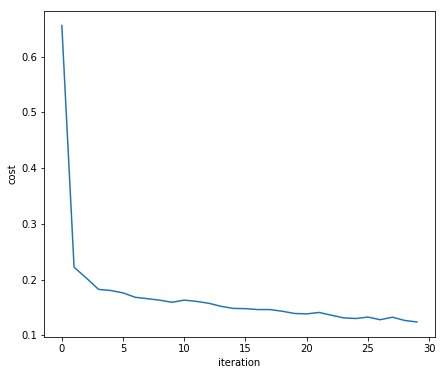

on the training set:
Accuracy: 0.9478672985781991
on the test set:
Accuracy: 0.915


In [71]:
parameters=model(train_X, train_Y)

print("on the training set:")

prediction_train=predict(train_X, train_Y, parameters) 

print("on the test set:")

prediction_test=predict(test_X,test_Y, parameters)

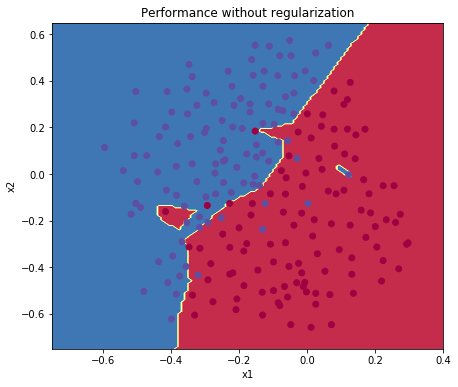

In [72]:
plt.title("Performance without regularization")

axes=plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])

plot_decision_boundary(lambda x: predict_dec(parameters, x.T),train_X, train_Y)